In [1]:
from platform import python_version
print(python_version())
# 3.7.0

3.7.0


In [2]:
from reframed import load_cbmodel
from reframed import Environment, CAFBA
from carveme.reconstruction.utils import load_media_db
from reframed import fluxes2escher
import copy
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from graph_functions import *

In [3]:
## Run simulation 1 (ecoli)
models = ["iJN1463.xml", "iJO1366.xml"]
objectives=["R_BIOMASS_KT2440_Core2", "R_BIOMASS_Ec_iJO1366_core_53p95M"]

sol_keys = ["pputida", "ecoli"]
solutions=dict()


mediadb="my_media.tsv"
medium= "M9"
media_db = load_media_db(mediadb, compound_col="compound")
init_env = Environment.from_compounds(media_db[medium])


f= models[1]
print("\nmodel: "+f+"\n==============")
model_e = load_cbmodel(f, flavor="fbc2")
init_env.apply(model_e)
solution = CAFBA(model_e,   objective=objectives[1])  
solutions[sol_keys[1]]=solution
print("solution "+str(solution))


model: iJO1366.xml
solution Objective: 0.7108706214472016
Status: Optimal



In [4]:
## Create spare medium (ecoli)
create_spare_medium(models[1], medium, media_db,outputdir=".",
                    include_original=True,to_remove=["glc__D"], 
                    objective=objectives[1]) # !!


mediadb="tempmedium.tsv"
medium="temp"
print("\nMedio: "+medium+"\n==============")
media_db = load_media_db(mediadb, compound_col="compound")
init_env = Environment.from_compounds(media_db[medium])


Medio: temp


In [5]:
## Run simulation 2 (pputida)
f= models[0]
print("\nmodel: "+f+"\n==============")
model = load_cbmodel(f,flavor="fbc2")
init_env.apply(model)
solution = CAFBA(model,   objective=objectives[0])  
solutions[sol_keys[0]]=solution
print("solution "+str(solution))


model: iJN1463.xml
solution Objective: 0.38676203435384926
Status: Optimal



In [6]:
## Filter reactions from solution (only pputida)
a, b = solutions['pputida'], solutions["ecoli"]
ar={v:a.values[v] for v in a.values.keys() if a.values[v]!=0}
br={v:b.values[v] for v in b.values.keys() if b.values[v]!=0}

full_common_reactions = {v:a.values[v] for v in ar.keys() if v in br.keys()}
specific_pputida = {v:a.values[v] for v in ar if v not in b.values.keys()}

R_CYTBO3_4pp:['h_c', 'o2_c', 'q8h2_c']-->['h2o_c', 'h_p', 'q8_c']
Didn't know how to parse this:  M_h2o_e <->  [-10.0, inf]
R_H2Otex:['h2o_e']-->['h2o_p']
R_H2Otpp:['h2o_p']-->['h2o_c']
R_NADH16pp:['h_c', 'nadh_c', 'q8_c']-->['h_p', 'nad_c', 'q8h2_c']
R_ATPS4rpp:['adp_c', 'h_p', 'pi_c']-->['atp_c', 'h2o_c', 'h_c']


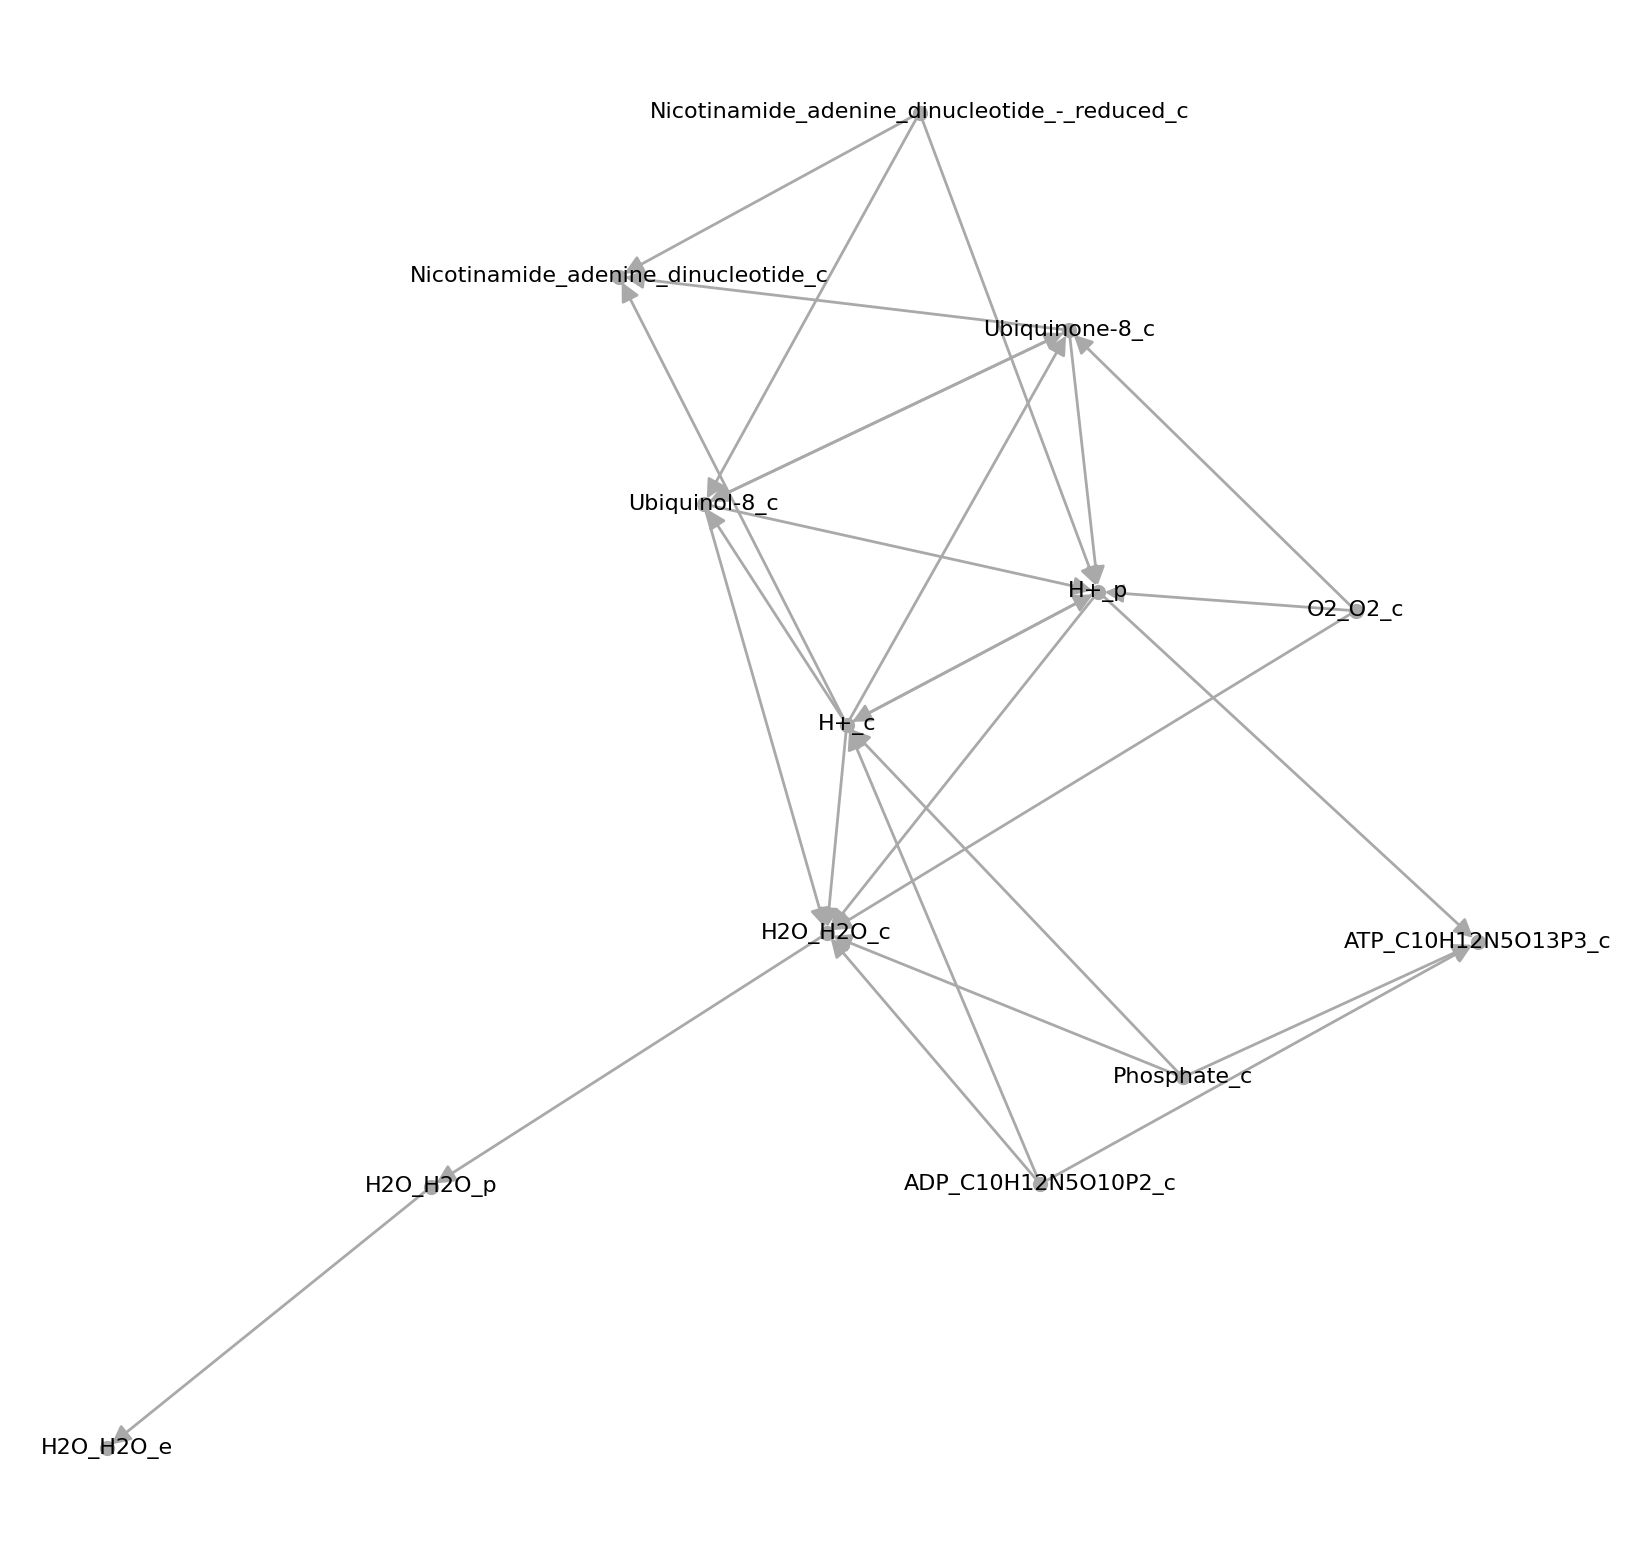

In [7]:
my_reactions = full_common_reactions
my_model = model

nt = "bigg_models_metabolites.txt"
code_to_name = metabolite_translator(nt)

exi=0
exr=0
textrot=0
fntsize=8
my_figsize=(10,10)

## We select only the most active reactions (flux > 10)
minf= 12

## We paint the unspecific reactions in grey
ax, first_graph = my_draw(my_model, my_reactions, code_to_name, exi, exr, minf, my_figsize, fntsize, textrot,
                         given_color="darkgrey")

R_FALDM:['fald_c', 'h2o_c']-->['for_c', 'h_c', 'meoh_c']
R_FDH:['for_c', 'nad_c']-->['co2_c', 'nadh_c']
R_FMNRx2_copy1:['fmn_c', 'h_c', 'nadph_c']-->['fmnh2_c', 'nadp_c']
R_PDHcr:['dhlam_c', 'nad_c']-->['h_c', 'lpam_c', 'nadh_c']
R_AKGDa:['akg_c', 'h_c', 'lpam_c']-->['co2_c', 'sdhlam_c']
R_AKGDb_copy1:['coa_c', 'sdhlam_c']-->['dhlam_c', 'succoa_c']
R_ALDD1:['fald_c', 'h2o_c', 'nad_c']-->['for_c', 'h_c', 'nadh_c']


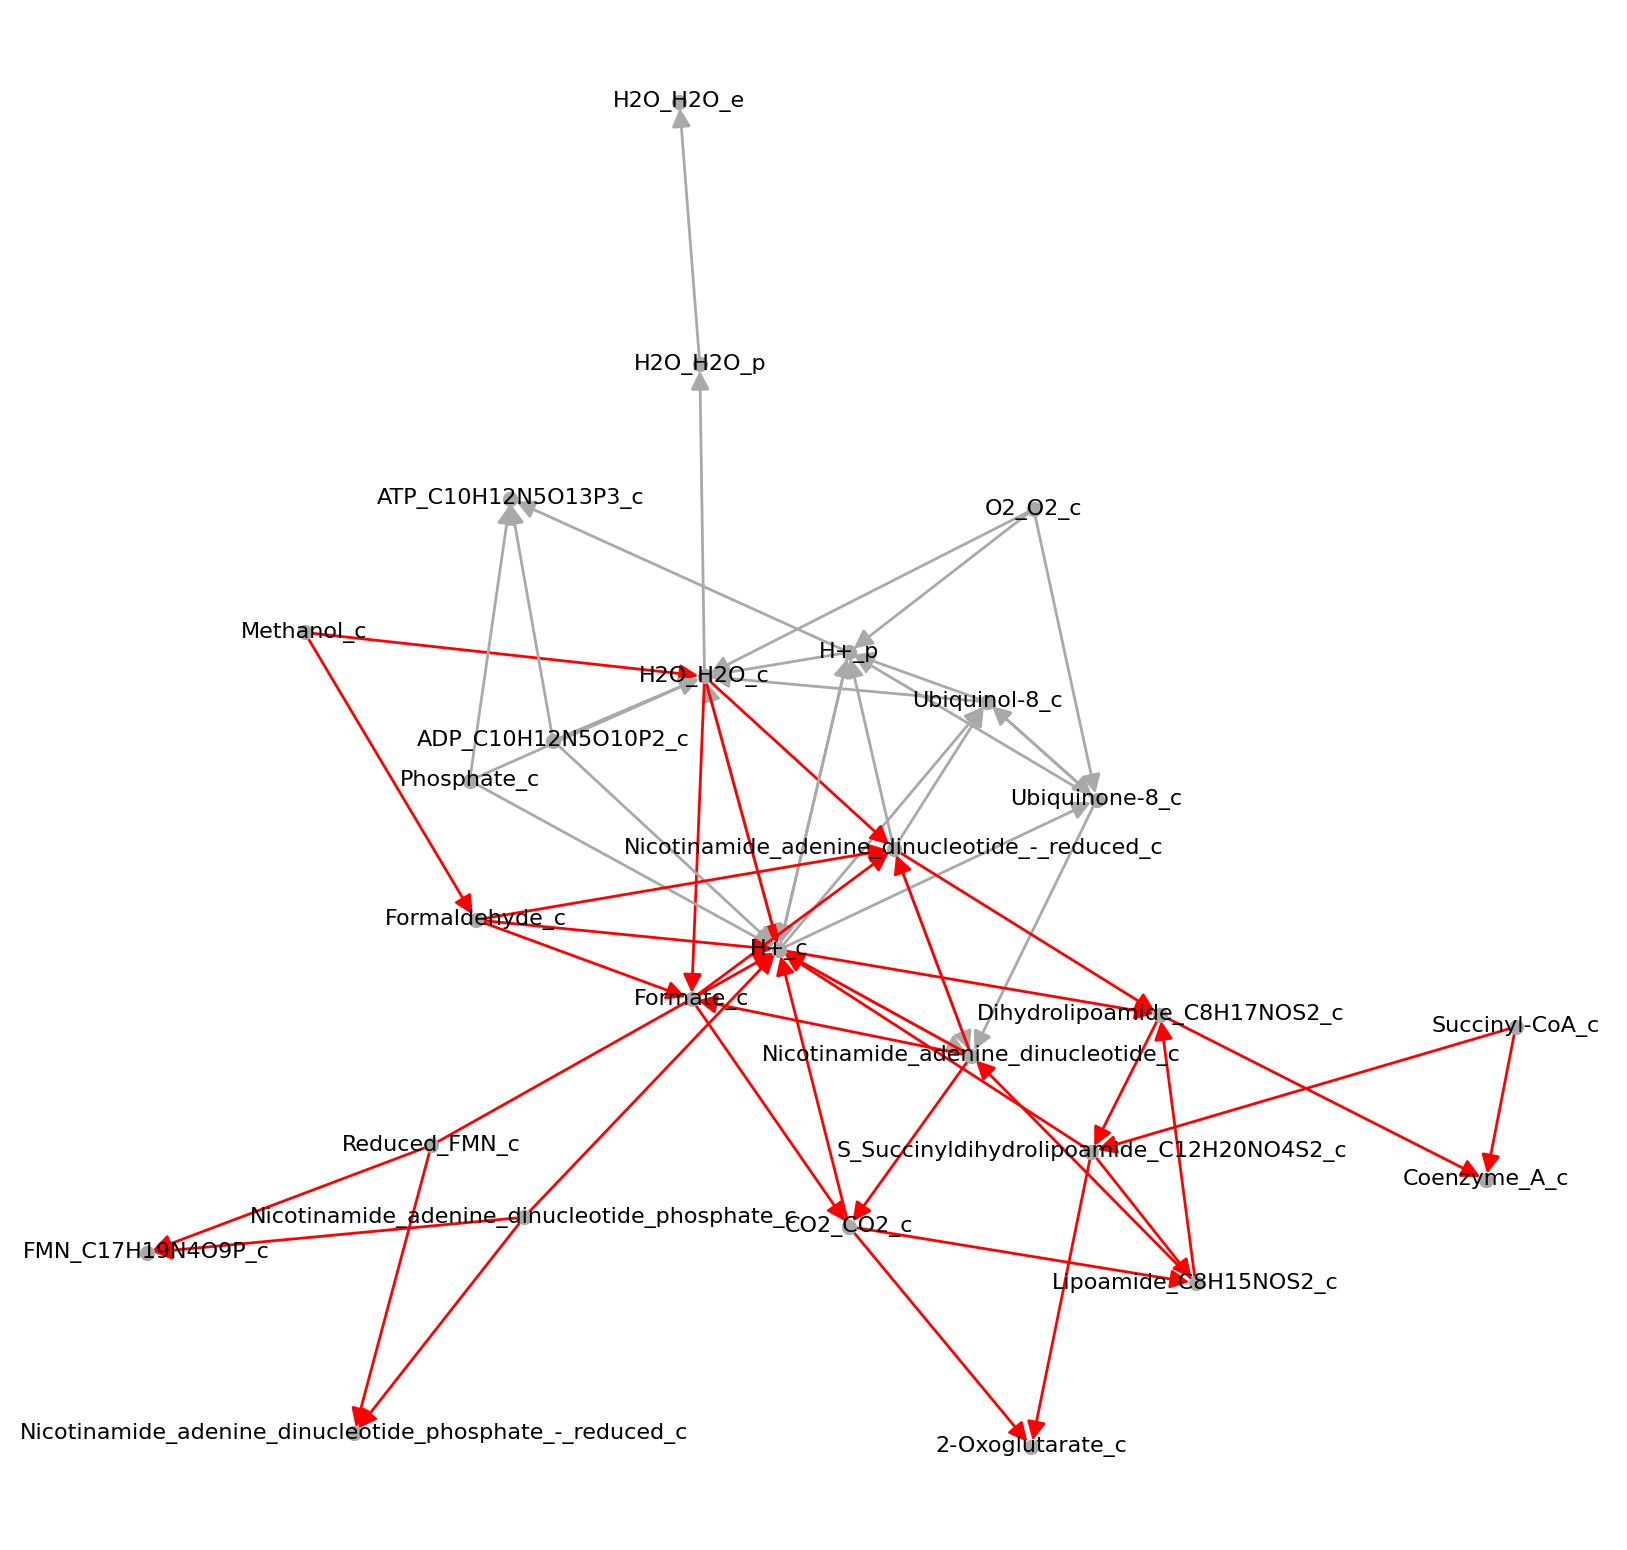

In [8]:
## And now on top of that we paint the specific reactions in red
my_reactions = specific_pputida
minf = 5
ax, full_graph = my_draw(my_model, my_reactions, code_to_name, exi, exr, minf, my_figsize, fntsize, textrot,
                         given_color="red", 
                         adj_list=first_graph)

R_FALDM:['fald_c', 'h2o_c']-->['for_c', 'h_c', 'meoh_c']
R_FDH:['for_c', 'nad_c']-->['co2_c', 'nadh_c']
R_FMNRx2_copy1:['fmn_c', 'h_c', 'nadph_c']-->['fmnh2_c', 'nadp_c']
R_PDHcr:['dhlam_c', 'nad_c']-->['h_c', 'lpam_c', 'nadh_c']
R_AKGDa:['akg_c', 'h_c', 'lpam_c']-->['co2_c', 'sdhlam_c']
R_AKGDb_copy1:['coa_c', 'sdhlam_c']-->['dhlam_c', 'succoa_c']
R_ALDD1:['fald_c', 'h2o_c', 'nad_c']-->['for_c', 'h_c', 'nadh_c']


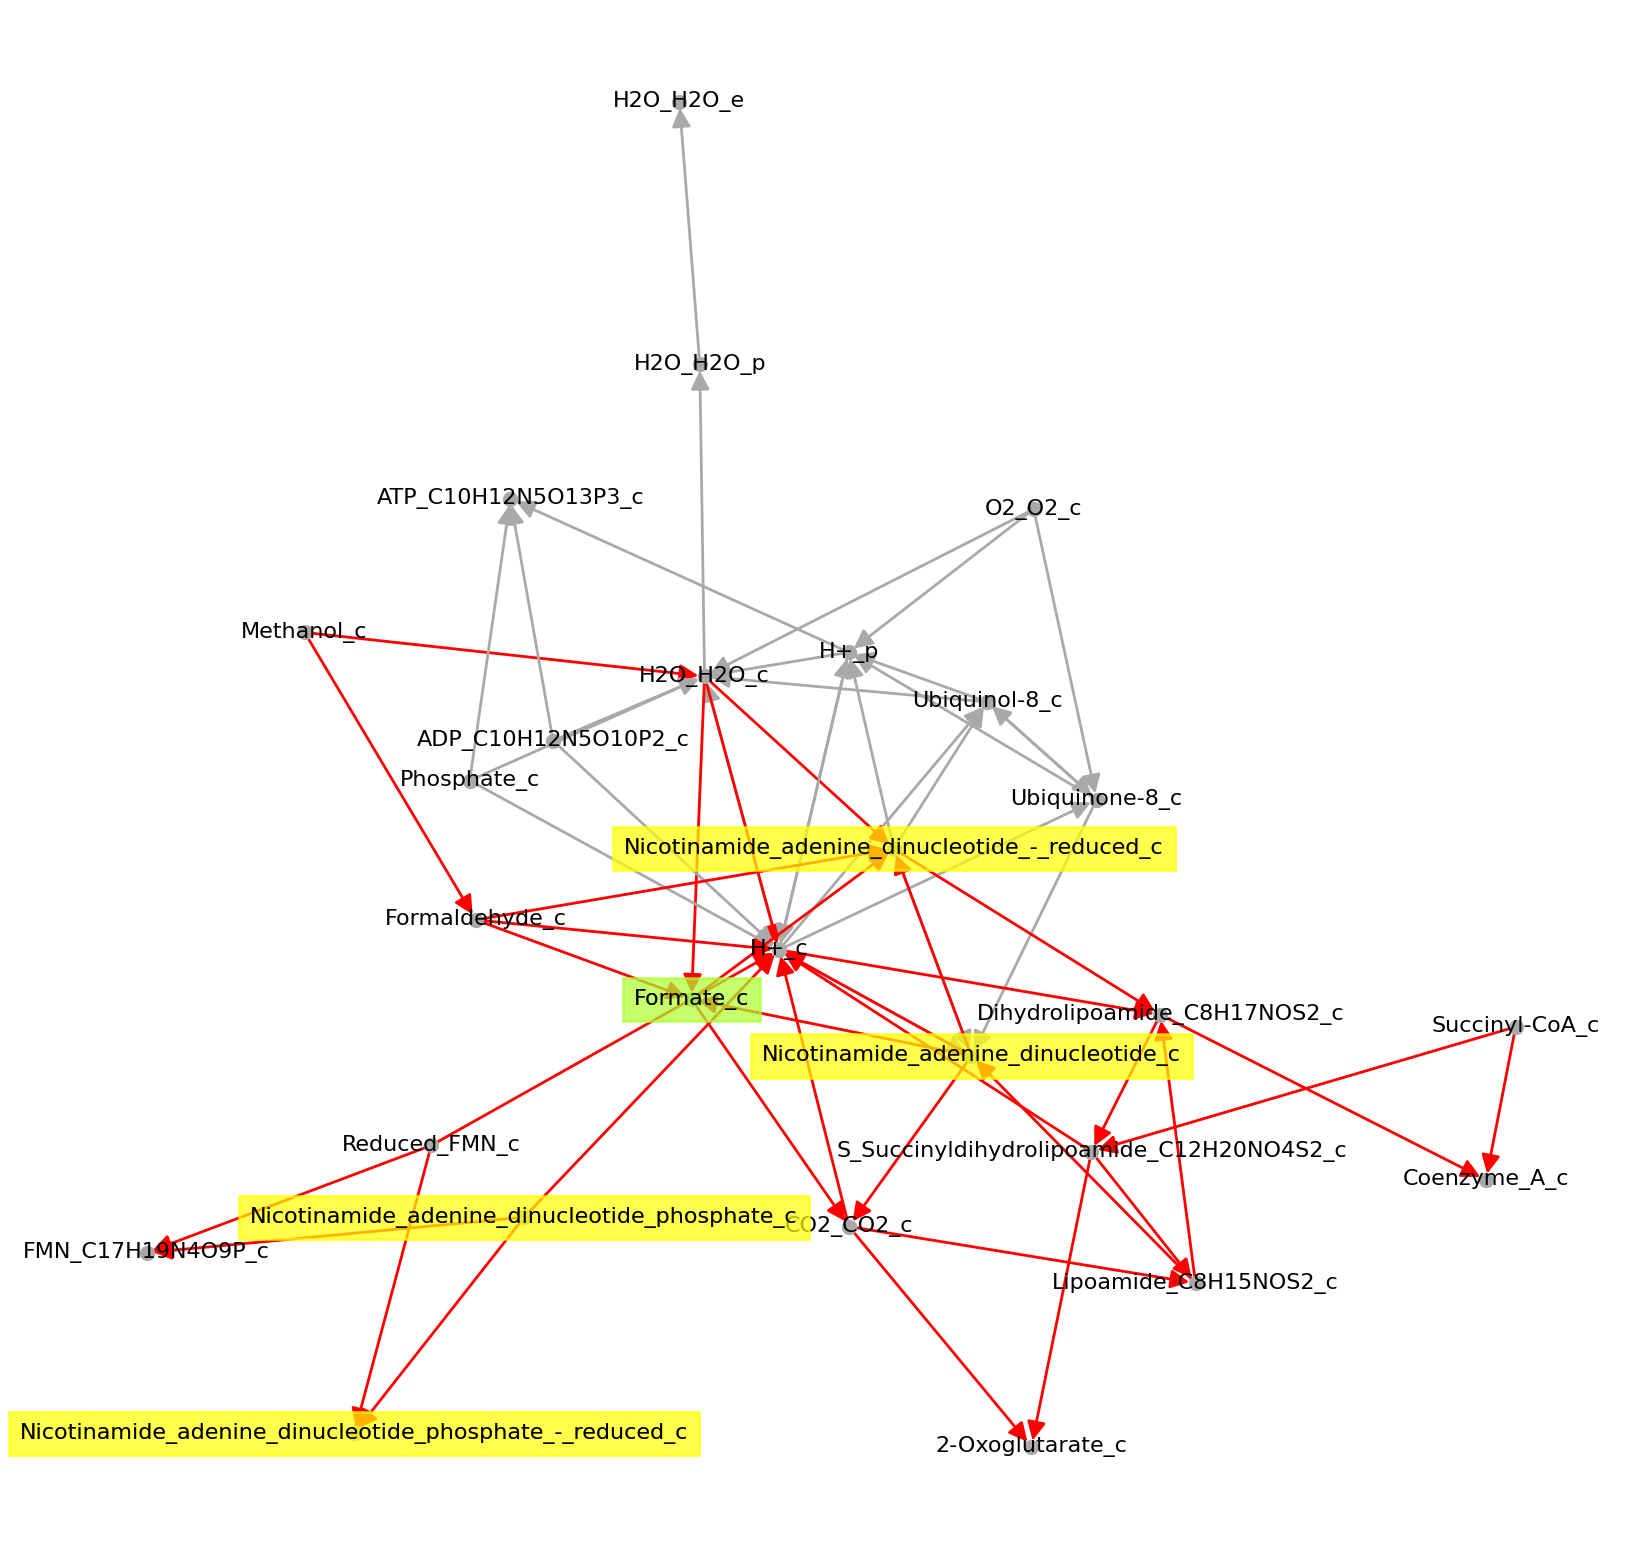

In [9]:
## Now let's highlight some metabolites we're interested in
ax, full_graph = my_draw(my_model, my_reactions, code_to_name, exi, exr, minf, my_figsize, fntsize, textrot,
                         given_color="red", 
                         adj_list=first_graph,
# We could also add some box to the non-highlighted metabolites, like this:
#                         label_options = {"ec": "k", "fc": "white", "alpha": 0.7},
                         highlight={"yellow": ["Nicotinamide_adenine_dinucleotide_c",
                                               "Nicotinamide_adenine_dinucleotide_-_reduced_c",
                                               "Nicotinamide_adenine_dinucleotide_phosphate_c",
                                               "Nicotinamide_adenine_dinucleotide_phosphate_-_reduced_c"],
                                    "greenyellow" : ["Formate_c"]
                                   }
                        )